In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import os
from glob import glob
from scipy import stats
import itertools as it
from sklearn import metrics
from matplotlib.patches import ConnectionPatch as connpatch

In [245]:
def singifscalar(scalar, limits=[1e-4,1e-3,1e-2]):
    if scalar <= limits[0]:
        return '***'
    if scalar <= limits[1]:
        return '**'
    if scalar <= limits[2]:
        return '*'
    return 'n.s.'

In [246]:
def singifmtx(mwhit, limits=[1e-4,1e-3,1e-2]):
    smwhit = np.zeros_like(mwhit, dtype='<U5')
    for i in range(mwhit.shape[0]):
        for j in range(mwhit.shape[1]):
            smwhit[i,j] = singifscalar(mwhit[i,j])
    return smwhit

limits = limits=[5e-4,5e-3,5e-2]

In [3]:
manudf = pd.read_csv('../raw/20231003-Max-raw-data.csv')
coilstart = manudf.iloc[:7, 4:9].values.flatten()
inoctime = manudf.iloc[:7, 10:15].values.flatten()
manu = {'9am': np.column_stack((coilstart, inoctime))}

coilstart = manudf.iloc[7:14, 4:9].values.flatten()
inoctime = manudf.iloc[7:14, 10:15].values.flatten()
mask = np.isnan(coilstart) | np.isnan(inoctime)
manu['12pm'] = np.column_stack((coilstart[~mask], inoctime[~mask]))

coilstart = manudf.iloc[14:, 4:9].values.flatten()
inoctime = manudf.iloc[14:, 10:15].values.flatten()
mask = np.isnan(coilstart) | np.isnan(inoctime)
manu['4pm'] = np.column_stack((coilstart[~mask], inoctime[~mask]))

In [157]:
colors = ['#117733', '#aa4499', '#332288', '#44aa99', '#88ccee', '#ddcc77']
markers = ['D','o','^','v','<','>','*']
fs = 15

src = '../proc/prelim/'
dst = '../proc/plots/'
csvfiles = glob(src + '*/*.csv')
Times = ['9am','12pm','4pm']
csvfiles[:5]

['../proc/prelim/9am_rep4/9am_rep4_plant_02.csv',
 '../proc/prelim/9am_rep4/9am_rep4_plant_03.csv',
 '../proc/prelim/9am_rep4/9am_rep4_plant_01.csv',
 '../proc/prelim/9am_rep4/9am_rep4_plant_00.csv',
 '../proc/prelim/9am_rep4/9am_rep4_plant_04.csv']

In [5]:
manuct = np.zeros(len(Times), dtype=float)
manuct[0] = np.sum(manudf.iloc[:7, 3].values)
manuct[1] = np.sum(manudf.iloc[7:14, 3].values)
manuct[2] = np.sum(manudf.iloc[14:, 3].values)
manuct = manuct/35

In [6]:
autoct = np.zeros_like(manuct)
dfs = dict(zip(Times, [ [] for i in range(len(Times)) ] ))
meta = dict(zip(Times, [ [] for i in range(len(Times)) ] ))

for i in range(len(csvfiles)):
    time, rep, _, pidx = os.path.splitext(os.path.split(csvfiles[i])[1])[0].split('_')
    df = pd.read_csv(csvfiles[i])
    df['timestamp'] *= 96/3600
    df = df.iloc[np.argmax((df.pos_raw_1 != -100).values):, :]
    if (df.shape[1]-1)//6 > 1:
        dfs[time].append(df)
        meta[time].append(np.asarray([rep[-1], pidx, *df.shape]).astype(int))
i = 0
for key in meta:
    meta[key] = np.asarray(meta[key])
    autoct[i] = meta[key].shape[0] / (5*np.max(meta[key][:,0]))
    print(key, meta[key].shape, autoct[i], sep='\t')
    i += 1

9am	(34, 4)	0.9714285714285714
12pm	(21, 4)	0.7
4pm	(28, 4)	0.8


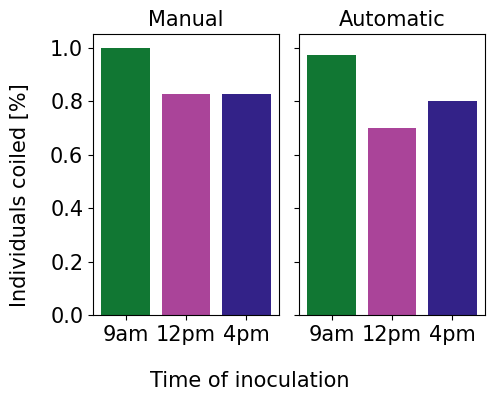

In [7]:
fig, ax = plt.subplots(1,2, figsize=(5,4), sharey=True, sharex=True)
ax = np.atleast_1d(ax).ravel()    

ax[0].set_title('Manual', fontsize=fs)
ax[1].set_title('Automatic', fontsize=fs)

for i,foo in enumerate([manuct, autoct]):
    ax[i].bar(range(len(Times)), foo, color=colors[:len(Times)])

for i in range(len(ax)):
    ax[i].set_xticks(range(len(Times)), Times)
    ax[i].tick_params(labelsize=fs)

fig.supxlabel('Time of inoculation', fontsize=fs)
fig.supylabel('Individuals coiled [%]', fontsize=fs)
fig.tight_layout();

filename = dst + 'coil_percentage'
#plt.savefig(filename + '.svg', format='svg', bbox_inches='tight')
#plt.savefig(filename + '.jpg', format='jpg', dpi=200, pil_kwargs={'optimize':True}, bbox_inches='tight')

# Plot all individual cuscutas at once

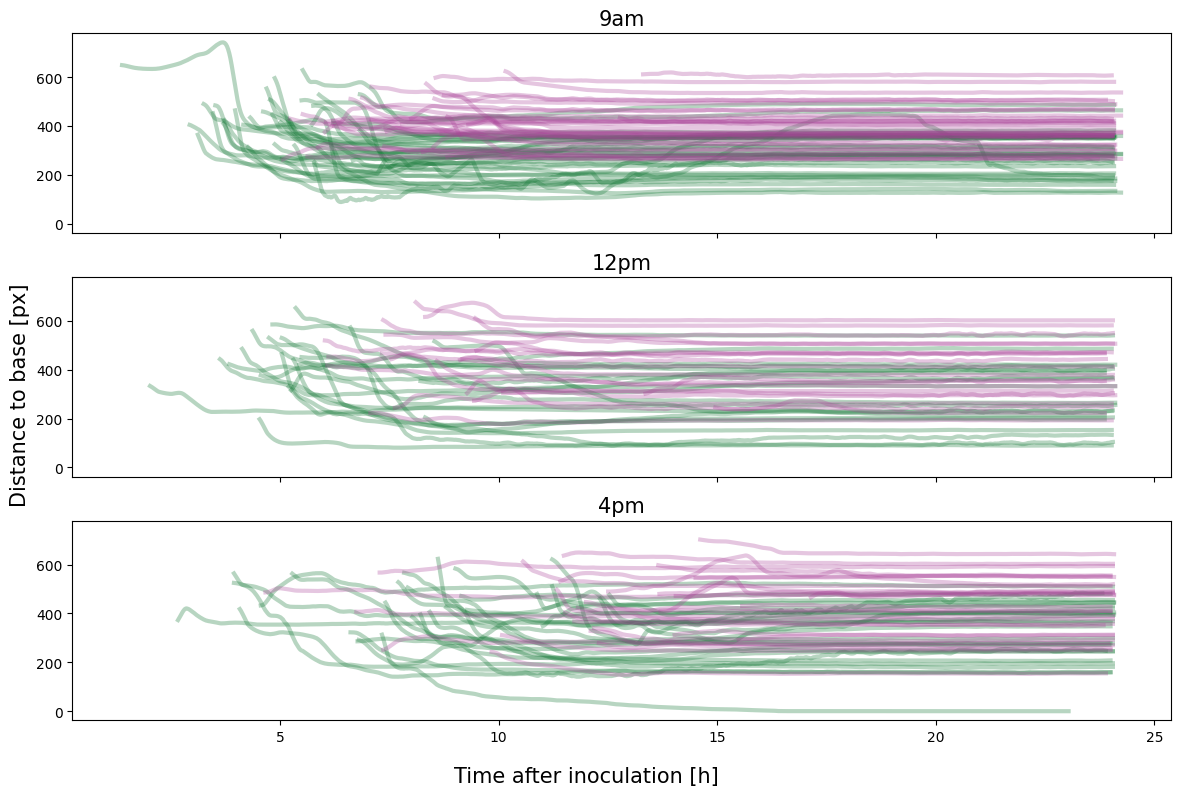

In [8]:
fig, ax = plt.subplots(3,1, figsize=(12,8), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0

for k in range(len(Times)):
    key = Times[k]
    ax[k].set_title(Times[k], fontsize=fs)
    for i in range(len(dfs[key])):
        df = dfs[key][i]
        
        for j in range(2):
            anglab = 'angle_sg_{}'.format(j+1)
            rposlab = 'pos_raw_{}'.format(j+1)
            poslab = 'pos_sg_{}'.format(j+1)
            mask = df[rposlab] > 0
            ax[k].plot(df['timestamp'].loc[mask], df[poslab].loc[mask], lw=3, color=colors[j], alpha=0.3, zorder=j+1)

for i in range(len(ax)):
    ax[i].tick_params(labelsize=fs-5)
            
fig.supxlabel('Time after inoculation [h]', fontsize=fs)
fig.supylabel('Distance to base [px]', fontsize=fs)
fig.tight_layout()

filename = dst + 'all_positions'
#plt.savefig(filename + '.svg', format='svg', dpi=200, bbox_inches='tight')
#plt.savefig(filename + '.jpg', format='jpg', dpi=200, pil_kwargs={'optimize':True}, bbox_inches='tight')

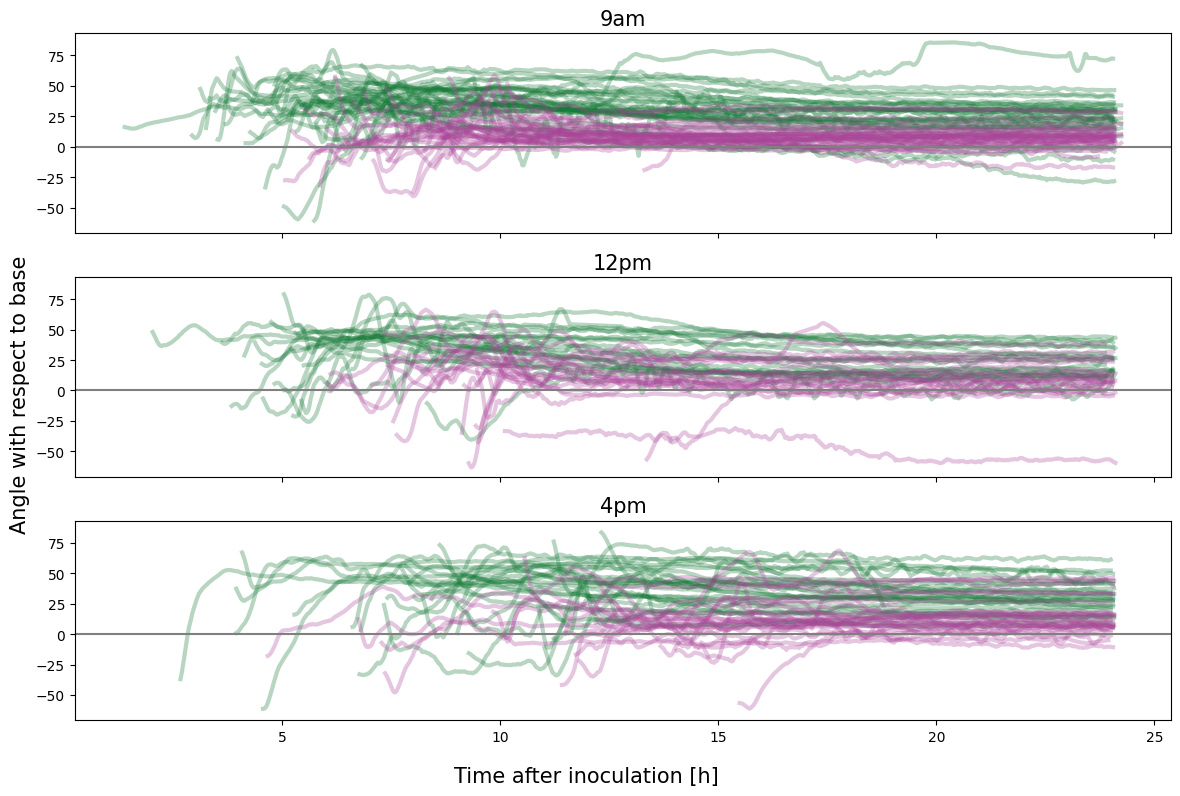

In [9]:
fig, ax = plt.subplots(3,1, figsize=(12,8), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0

for k in range(len(Times)):
    key = Times[k]
    ax[k].set_title(Times[k], fontsize=fs)
    for i in range(len(dfs[key])):
        df = dfs[key][i]
        
        for j in range(2):
            anglab = 'angle_sg_{}'.format(j+1)
            rposlab = 'pos_raw_{}'.format(j+1)
            poslab = 'pos_sg_{}'.format(j+1)
            mask = df[rposlab] > 0
            ax[k].plot(df['timestamp'].loc[mask], df[anglab].loc[mask], lw=3, color=colors[j], alpha=0.3, zorder=j+1)

for i in range(len(ax)):
    ax[i].tick_params(labelsize=fs-5)
    ax[i].axhline(0, c='gray')
            
fig.supxlabel('Time after inoculation [h]', fontsize=fs)
fig.supylabel('Angle with respect to base', fontsize=fs)
fig.tight_layout()

filename = dst + 'all_angles'
#plt.savefig(filename + '.svg', format='svg', dpi=200, bbox_inches='tight')
#plt.savefig(filename + '.jpg', format='jpg', dpi=200, pil_kwargs={'optimize':True}, bbox_inches='tight')

# Find at which timestamp the cuscuta gets infront of the skewer

## Then at which timestamp the cuscuta gets infront of the skewer for a 2nd time

### The latter can be seen as the time it takes cuscuta to coil itself around the skewer.

We then perform Mann-Whitney U-tests to see if the differences are statistically significant

In [93]:
times = dict()

for key in dfs:
    time = np.random.default_rng(42).normal(0, 0.1, size=(len(dfs[key]), 2))
    for i in range(len(dfs[key])):
        for j in range(2):
            anglab = 'angle_sg_{}'.format(j+1)
            poslab = 'pos_sg_{}'.format(j+1)
            rposlab = 'pos_raw_{}'.format(j+1)
    
            mask = dfs[key][i][rposlab] > 0
            time[i,j] += dfs[key][i]['timestamp'].iloc[np.argmax(mask)]

    times[key] = time

speed = dict()

for key in dfs:
    s = np.diff(times[key], axis=1).squeeze().astype(float)
    speed[key] = s

buff = 50
angles = dict()
positions = dict()

for key in dfs:
    angle = np.zeros((len(dfs[key]), 2))
    position = np.copy(angle)
    
    for i in range(len(angle)):
        df = dfs[key][i].iloc[-buff-10:-10]
        for j in range(2):
            anglab = 'angle_sg_{}'.format(j+1)
            poslab = 'pos_sg_{}'.format(j+1)
            
            angle[i,j] = np.median(df[anglab].values)
            position[i,j] = np.median(df[poslab].values)

    angles[key] = angle
    positions[key] = position

tight = dict()

for key in dfs:
    s = np.diff(positions[key], axis=1).squeeze().astype(float)
    tight[key] = s

tolpos, tolang = 14, 5

stables = dict()
quicks = dict()

for key in dfs:
    stable = np.zeros((len(dfs[key]), 2))
    quick = np.copy(stable)
    
    for i in range(len(stable)):
        for j in range(2):
            poslab = 'pos_sg_{}'.format(j+1)
            anglab = 'angle_sg_{}'.format(j+1)
            
            maskpos = np.abs(dfs[key][i][poslab] - positions[key][i,j]) < tolpos
            maskang = np.abs(dfs[key][i][anglab] - angles[key][i,j]) < tolang
            
            foo = np.nonzero(maskpos & maskang)[0]
            bar = np.nonzero(np.hstack( ([0], np.ediff1d(foo) != 1) ) )[0]
            if len(bar) == 0:
                tt = foo[0]
            else:
                tt = foo[bar[-1]]

            stable[i,j] = dfs[key][i].loc[:, ['timestamp', poslab]].iloc[tt:, :].iloc[0,0]
            quick[i,j] = stable[i,j] - times[key][i,j]
            
    quicks[key] = quick
    stables[key] = stable

for key in dfs:
    positions[key] /= 28
    tight[key] /= 28

foo = [None for i in range(len(Times))]

In [247]:
hmax = max([np.max(times[Times[i]]) for i in range(len(Times))] + [np.max(manu[Times[i]][:,0]) for i in range(len(Times))])
hmin = max([np.min(times[Times[i]]) for i in range(len(Times))] + [np.min(manu[Times[i]][:,0]) for i in range(len(Times))])

print(hmax, hmin)

mwhit = np.zeros((3,3))

for ix,(i,j) in enumerate(it.combinations(range(len(Times)), 2)):
    mwhit[ix, 0] = stats.mannwhitneyu(manu[Times[i]][:,0], manu[Times[j]][:, 0], method='exact').pvalue
    print('Manual\t',Times[i],'vs',Times[j],'\tMann-Whitney U-test p-val:',mwhit[ix,0])
    for k in range(2):
        mwhit[ix,k+1] = stats.mannwhitneyu(times[Times[i]][:,k], times[Times[j]][:, k], method='exact').pvalue
        print('Coil', k+1, '\t', Times[i],'vs',Times[j],'\tMann-Whitney U-test p-val:', mwhit[ix,k+1])
    print('---')

smwhit = singifmtx(mwhit, limits)
print(smwhit)

19.0 3.0
Manual	 9am vs 12pm 	Mann-Whitney U-test p-val: 0.06638497413147994
Coil 1 	 9am vs 12pm 	Mann-Whitney U-test p-val: 0.5532004607307406
Coil 2 	 9am vs 12pm 	Mann-Whitney U-test p-val: 0.08478328879351145
---
Manual	 9am vs 4pm 	Mann-Whitney U-test p-val: 1.1027317294134446e-12
Coil 1 	 9am vs 4pm 	Mann-Whitney U-test p-val: 1.3522896572005776e-06
Coil 2 	 9am vs 4pm 	Mann-Whitney U-test p-val: 9.914453424252958e-08
---
Manual	 12pm vs 4pm 	Mann-Whitney U-test p-val: 1.4347280043118815e-07
Coil 1 	 12pm vs 4pm 	Mann-Whitney U-test p-val: 0.0005722840896619024
Coil 2 	 12pm vs 4pm 	Mann-Whitney U-test p-val: 8.456304762066346e-05
---
[['n.s.' 'n.s.' 'n.s.']
 ['***' '***' '***']
 ['***' '**' '***']]


Manual	median	mean	std	sem
9am	[4.   3.74 0.77 0.13]
12pm	[4.   4.83 2.69 0.5 ]
4pm	[9.   9.24 3.35 0.62]

Coil 1	median	mean	std	sem
9am	[4.93 4.83 1.23 0.21]
12pm	[5.13 5.29 1.53 0.33]
4pm	[7.95 7.93 2.58 0.49]

Coil 2	median	mean	std	sem
9am	[7.45 7.76 1.88 0.32]
12pm	[8.39 8.65 2.17 0.47]
4pm	[12.06 11.9   2.79  0.53]


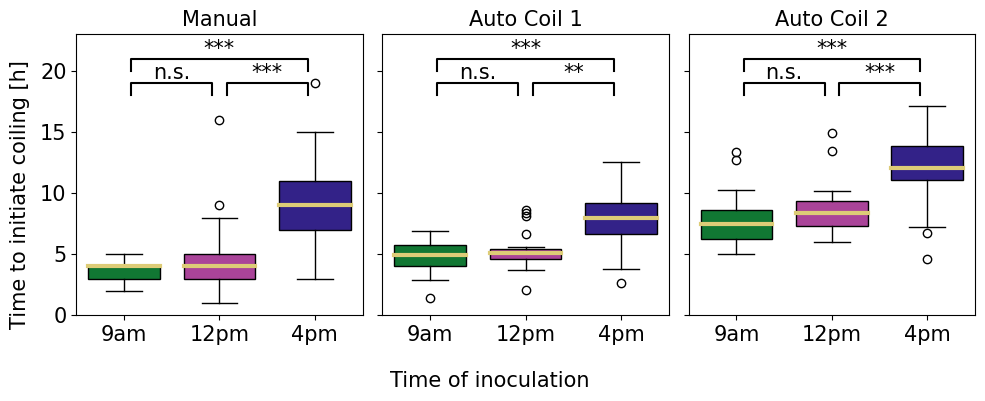

In [24]:
fs = 15

fig, ax = plt.subplots(1,3, figsize=(10,4), sharey=True, sharex=True)
ax = np.atleast_1d(ax).ravel()    

print('Manual\tmedian\tmean\tstd\tsem')
ax[0].set_title('Manual', fontsize=fs)
for i in range(len(foo)):
    foo[i] = manu[Times[i]][:,0]
    print(Times[i], np.round([np.median(foo[i]), np.mean(foo[i]), np.std(foo[i]), np.std(foo[i])/np.sqrt(len(foo[i]))], 2) , sep='\t')

bplot = ax[0].boxplot(foo, widths=0.75, patch_artist=True, 
                  medianprops={'lw':3, 'color':colors[5]})
for patch, color in zip(bplot['boxes'], colors[:len(Times)]):
    patch.set_facecolor(color)

for k in range(2):
    ax[k+1].set_title('Auto Coil {}'.format(k+1), fontsize=fs)
    print('\nCoil {}\tmedian\tmean\tstd\tsem'.format(k+1))
    for i in range(len(foo)):
        foo[i] = times[Times[i]][:,k]
        print(Times[i], np.round([np.median(foo[i]), np.mean(foo[i]), np.std(foo[i]), np.std(foo[i])/np.sqrt(len(foo[i]))], 2) , sep='\t')
        
    bplot = ax[k+1].boxplot(foo, widths=0.75, patch_artist=True, 
                      medianprops={'lw':3, 'color':colors[5]})
    for patch, color in zip(bplot['boxes'], colors[:len(Times)]):
        patch.set_facecolor(color)

epsx = 0.075
for ix,(i,j) in enumerate(it.combinations(range(len(Times)), 2)):
    if i+j == 2:
        epsy = 2
    else:
        epsy = 0
    xfoo = np.array([i+1+epsx, i+1+epsx, j+1-epsx, j+1-epsx])
    yfoo = np.array([hmax-1,hmax,hmax,hmax-1]) + epsy
    
    for k in range(len(ax)):    
        ax[k].text((xfoo[0] + xfoo[2])*.5, yfoo[0]+1, smwhit[ix,k], ha='center', va='bottom', color='k', fontsize=fs)
        ax[k].plot(xfoo, yfoo, lw=1.5, c='k')

for i in range(len(ax)):
    #ax[i].margins(x = 0.05)
    ax[i].set_xticks(range(1,4), Times)
    ax[i].tick_params(labelsize=fs)
    ax[i].set_ylim((0,hmax+4))

fig.supylabel('Time to initiate coiling [h]', fontsize=fs)
fig.supxlabel('Time of inoculation', fontsize=fs)
fig.tight_layout();

filename = dst + 'time_after_inoculation'
#plt.savefig(filename + '.svg', format='svg', bbox_inches='tight')
#plt.savefig(filename + '.jpg', format='jpg', dpi=200, pil_kwargs={'optimize':True}, bbox_inches='tight')

In [14]:
mwhit = np.zeros((1,3))

for ix,(i,j) in enumerate(it.combinations(range(len(Times)), 2)):
    mwhit[0,ix] = stats.mannwhitneyu(speed[Times[i]], speed[Times[j]], method='exact').pvalue
    print('Coil', k+1, '\t', Times[i],'vs',Times[j],'\tMann-Whitney U-test p-val:', mwhit[0,ix])

smwhit = singifmtx(mwhit, limits)
print(smwhit)

hmin = min([np.min(speed[key]) for key in speed])
hmax = max([np.max(speed[key]) for key in speed])
print(hmin, hmax)

Coil 3 	 9am vs 12pm 	Mann-Whitney U-test p-val: 0.11347049559413055
Coil 3 	 9am vs 4pm 	Mann-Whitney U-test p-val: 0.01846832488264103
Coil 3 	 12pm vs 4pm 	Mann-Whitney U-test p-val: 0.5279580244565482
[['n.s.' '*' 'n.s.']]
0.9298470000823649 10.624885568179153


Speed	median	mean	std	sem
9am	[2.64 2.94 1.27 0.22]
12pm	[3.15 3.37 1.2  0.26]
4pm	[3.42 3.97 1.96 0.37]


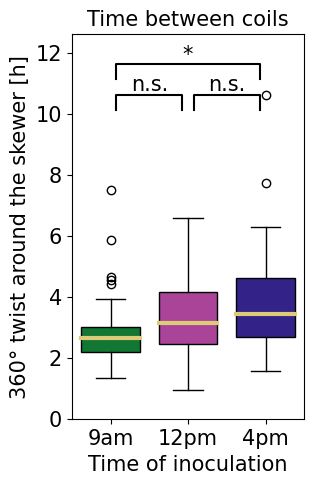

In [15]:
fig, ax = plt.subplots(1,1, figsize=(3,5), sharey=True, sharex=True)
ax = np.atleast_1d(ax).ravel(); i=0

print('Speed\tmedian\tmean\tstd\tsem')
for i in range(len(foo)):
    foo[i] = speed[ Times[i] ]
    print(Times[i], np.round([np.median(foo[i]), np.mean(foo[i]), np.std(foo[i]), np.std(foo[i])/np.sqrt(len(foo[i]))], 2) , sep='\t')

bplot = ax[0].boxplot(foo, 
                      widths=0.75, patch_artist=True, 
                      medianprops={'lw':3, 'color':colors[5], 'alpha':1}, zorder=3)
for patch, color in zip(bplot['boxes'], colors[:len(Times)]):
    patch.set_facecolor(color)

for ix,(i,j) in enumerate(it.combinations(range(len(Times)), 2)):
    if i+j == 2:
        epsy = 1
    else:
        epsy = 0
    xfoo = np.array([i+1+epsx, i+1+epsx, j+1-epsx, j+1-epsx])
    yfoo = np.array([hmax-0.5,hmax,hmax,hmax-0.5]) + epsy
    ax[0].text((xfoo[0] + xfoo[2])*.5, yfoo[0]+0.5, smwhit[0,ix], ha='center', va='bottom', color='k', fontsize=fs)
    ax[0].plot(xfoo, yfoo, lw=1.5, c='k')

i = 0
ax[i].set_ylim((0,hmax+2))
ax[i].tick_params(labelsize=fs);
ax[i].set_xticks(np.arange(len(Times)) + 1, Times, fontsize=fs);
ax[i].set_ylabel('360° twist around the skewer [h]', fontsize=fs);
ax[i].set_xlabel('Time of inoculation', fontsize=fs)
ax[i].set_title('Time between coils', fontsize=fs);

filename = dst + 'time_for_360_twist'
#plt.savefig(filename + '.svg', format='svg', bbox_inches='tight')
#plt.savefig(filename + '.jpg', format='jpg', dpi=200, pil_kwargs={'optimize':True}, bbox_inches='tight')

# Most of the cuscutas reach a terminal angle and position

## Compare the final position and angle across inoculation times

In [16]:
mwhit = np.zeros((3,2))
for ix,(i,j) in enumerate(it.combinations(range(len(Times)), 2)):
    for k in range(2):
        mwhit[ix,k] = stats.mannwhitneyu(angles[Times[i]][:,k], angles[Times[j]][:,k], method='exact').pvalue
        print('Coil', k+1, '\t', Times[i],'vs',Times[j],'\tMann-Whitney U-test p-val:', mwhit[ix,k])
    print('---')
smwhit = singifmtx(mwhit, limits)
print(smwhit)

hmin = min([np.min(angles[Times[i]]) for i in range(len(Times))])
hmax = max([np.max(angles[Times[i]]) for i in range(len(Times))])
print(hmin, hmax)

Coil 1 	 9am vs 12pm 	Mann-Whitney U-test p-val: 0.4440471346026913
Coil 2 	 9am vs 12pm 	Mann-Whitney U-test p-val: 0.5080412983117383
---
Coil 1 	 9am vs 4pm 	Mann-Whitney U-test p-val: 0.14018214652516212
Coil 2 	 9am vs 4pm 	Mann-Whitney U-test p-val: 0.14405800977991262
---
Coil 1 	 12pm vs 4pm 	Mann-Whitney U-test p-val: 0.03754876884799503
Coil 2 	 12pm vs 4pm 	Mann-Whitney U-test p-val: 0.5279580244565482
---
[['n.s.' 'n.s.']
 ['n.s.' 'n.s.']
 ['*' 'n.s.']]
-57.19375620788887 72.18859714217456



Coil 1	median	mean	std	sem
9am	[24.8  23.49 17.23  2.95]
12pm	[19.78 21.8  12.65  2.76]
4pm	[29.42 30.39 13.45  2.54]

Coil 2	median	mean	std	sem
9am	[7.54 8.05 9.14 1.57]
12pm	[ 9.17  9.01 18.47  4.03]
4pm	[10.05 13.94 14.39  2.72]


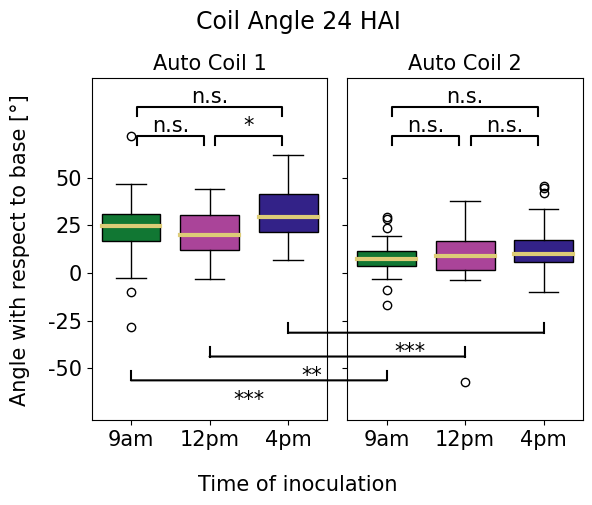

In [17]:
eps = 5

fig, ax = plt.subplots(1,2, figsize=(6,5), sharey=True, sharex=True)
ax = np.atleast_1d(ax).ravel()

for k in range(len(ax)):
    ax[k].set_title('Auto Coil {}'.format(k+1), fontsize=fs)
    print('\nCoil {}\tmedian\tmean\tstd\tsem'.format(k+1))
    for i in range(len(foo)):
        foo[i] = angles[Times[i]][:,k]
        print(Times[i], np.round([np.median(foo[i]), np.mean(foo[i]), np.std(foo[i]), np.std(foo[i])/np.sqrt(len(foo[i]))], 2) , sep='\t')
        
    bplot = ax[k].boxplot(foo, widths=0.75, patch_artist=True, 
                      medianprops={'lw':3, 'color':colors[5]})
    for patch, color in zip(bplot['boxes'], colors[:len(Times)]):
        patch.set_facecolor(color)

    ax[k].set_xticks(range(1,4), Times)
    ax[k].tick_params(labelsize=fs)
    ax[k].set_ylim((hmin - eps*4, hmax+eps*6))


epsx = 0.075
for ix,(i,j) in enumerate(it.combinations(range(len(Times)), 2)):
    if i+j == 2:
        epsy = 3*eps
    else:
        epsy = 0
    xfoo = np.array([i+1+epsx, i+1+epsx, j+1-epsx, j+1-epsx])
    yfoo = np.array([hmax-eps,hmax,hmax,hmax-eps]) + epsy
    
    for k in range(len(ax)):    
        ax[k].text((xfoo[0] + xfoo[2])*.5, yfoo[0]+eps, smwhit[ix,k], ha='center', va='bottom', color='k', fontsize=fs)
        ax[k].plot(xfoo, yfoo, lw=1.5, c='k')

yvals = -eps*2.5*(np.arange(2, -1, -1) + 2.5)

for i in range(len(yvals)):
    xy = (i+1, yvals[i])
    con = connpatch(xyA=xy, xyB=xy, coordsA='data', coordsB='data',
                    axesA=ax[0], axesB=ax[1], color="k", lw=1.5)
    ax[1].add_artist(con)

for i in range(len(yvals)):
    for j in range(len(ax)):
        ax[j].plot([i+1, i+1], [yvals[i]+eps, yvals[i]], lw=1.5, c='k')

ax[0].text( 2.5, yvals[0]-eps, '***', ha='center', va='top', color='k', fontsize=fs)
ax[0].text( 3.3, yvals[1]-eps, '**', ha='center', va='top', color='k', fontsize=fs)
ax[1].text( 1.3, yvals[2]-eps, '***', ha='center', va='top', color='k', fontsize=fs)

yticks = np.arange(-2,3)*25
ax[0].set_yticks(yticks, yticks)

fig.suptitle('Coil Angle 24 HAI', fontsize=fs+2)
fig.supxlabel('Time of inoculation', fontsize=fs)
fig.supylabel('Angle with respect to base [°]', fontsize=fs)
fig.tight_layout();

filename = dst + 'final_angle'
#plt.savefig(filename + '.svg', format='svg', bbox_inches='tight')
#plt.savefig(filename + '.jpg', format='jpg', dpi=200, pil_kwargs={'optimize':True}, bbox_inches='tight')

In [18]:
for i in range(len(Times)):
    print(Times[i], '\tcoil 1 vs 2\t', stats.mannwhitneyu(angles[Times[i]][:,0], angles[Times[i]][:,1], method='exact'))

9am 	coil 1 vs 2	 MannwhitneyuResult(statistic=956.0, pvalue=1.1472661422181409e-06)
12pm 	coil 1 vs 2	 MannwhitneyuResult(statistic=325.0, pvalue=0.007899885422807675)
4pm 	coil 1 vs 2	 MannwhitneyuResult(statistic=627.0, pvalue=6.675230647154674e-05)


In [19]:
mwhit = np.zeros((3,2))
for ix,(i,j) in enumerate(it.combinations(range(len(Times)), 2)):
    for k in range(2):
        mwhit[ix,k] = stats.mannwhitneyu(positions[Times[i]][:,k], positions[Times[j]][:,k], method='exact').pvalue
        print('Coil', k+1, '\t', Times[i],'vs',Times[j],'\tMann-Whitney U-test p-val:', mwhit[ix,k])
    print('---')
smwhit = singifmtx(mwhit, limits)
print(smwhit)

hmin = min([np.min(positions[Times[i]]) for i in range(len(Times))])
hmax = max([np.max(positions[Times[i]]) for i in range(len(Times))])
print(hmin, hmax)

Coil 1 	 9am vs 12pm 	Mann-Whitney U-test p-val: 0.7637572996635474
Coil 2 	 9am vs 12pm 	Mann-Whitney U-test p-val: 0.938412589178608
---
Coil 1 	 9am vs 4pm 	Mann-Whitney U-test p-val: 0.14018214652516212
Coil 2 	 9am vs 4pm 	Mann-Whitney U-test p-val: 0.3350677477344029
---
Coil 1 	 12pm vs 4pm 	Mann-Whitney U-test p-val: 0.3011174841018669
Coil 2 	 12pm vs 4pm 	Mann-Whitney U-test p-val: 0.3829037977760806
---
[['n.s.' 'n.s.']
 ['n.s.' 'n.s.']
 ['n.s.' 'n.s.']]
-0.07578236051505598 22.952426172898438



Coil 1	median	mean	std	sem
9am	[10.24 10.32  3.12  0.54]
12pm	[ 9.42 10.49  4.48  0.98]
4pm	[12.66 11.6   4.35  0.82]

Coil 2	median	mean	std	sem
9am	[13.34 14.07  3.13  0.54]
12pm	[13.52 14.04  4.18  0.91]
4pm	[14.93 15.02  4.4   0.83]


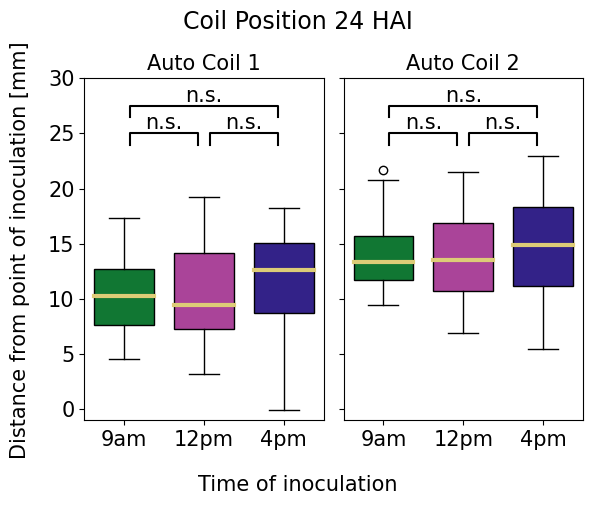

In [20]:
hmax = 25
eps = 1

fig, ax = plt.subplots(1,2, figsize=(6,5), sharey=True, sharex=True)
ax = np.atleast_1d(ax).ravel()    

for k in range(len(ax)):
    ax[k].set_title('Auto Coil {}'.format(k+1), fontsize=fs)
    print('\nCoil {}\tmedian\tmean\tstd\tsem'.format(k+1))
    for i in range(len(foo)):
        foo[i] = positions[Times[i]][:,k]
        print(Times[i], np.round([np.median(foo[i]), np.mean(foo[i]), np.std(foo[i]), np.std(foo[i])/np.sqrt(len(foo[i]))], 2) , sep='\t')
    bplot = ax[k].boxplot(foo, widths=0.75, patch_artist=True, 
                      medianprops={'lw':3, 'color':colors[5]})
    for patch, color in zip(bplot['boxes'], colors[:len(Times)]):
        patch.set_facecolor(color)

    ax[k].set_xticks(range(1,4), Times)
    ax[k].tick_params(labelsize=fs)
    ax[k].set_ylim((-1, 30))


epsx = 0.075
for ix,(i,j) in enumerate(it.combinations(range(len(Times)), 2)):
    if i+j == 2:
        epsy = 2.5*eps
    else:
        epsy = 0
    xfoo = np.array([i+1+epsx, i+1+epsx, j+1-epsx, j+1-epsx])
    yfoo = np.array([hmax-eps,hmax,hmax,hmax-eps]) + epsy
    
    for k in range(len(ax)):    
        ax[k].text((xfoo[0] + xfoo[2])*.5, yfoo[0]+eps, smwhit[ix,k], ha='center', va='bottom', color='k', fontsize=fs)
        ax[k].plot(xfoo, yfoo, lw=1.5, c='k')

fig.suptitle('Coil Position 24 HAI', fontsize=fs+2)
fig.supxlabel('Time of inoculation', fontsize=fs)
fig.supylabel('Distance from point of inoculation [mm]', fontsize=fs)
fig.tight_layout();

filename = dst + 'final_position'
#plt.savefig(filename + '.svg', format='svg', bbox_inches='tight')
#plt.savefig(filename + '.jpg', format='jpg', dpi=200, pil_kwargs={'optimize':True}, bbox_inches='tight')

# Check the distance between the two coils

In [21]:
mwhit = np.zeros((1,3))

for ix,(i,j) in enumerate(it.combinations(range(len(Times)), 2)):
    mwhit[0,ix] = stats.mannwhitneyu(tight[Times[i]], tight[Times[j]], method='exact').pvalue
    print('Coil', k+1, '\t', Times[i],'vs',Times[j],'\tMann-Whitney U-test p-val:', mwhit[0,ix])

smwhit = singifmtx(mwhit, limits)
print(smwhit)

hmin = min([np.min(tight[key]) for key in speed])
hmax = max([np.max(tight[key]) for key in speed])
print(hmin, hmax)

Coil 2 	 9am vs 12pm 	Mann-Whitney U-test p-val: 0.952080192482042
Coil 2 	 9am vs 4pm 	Mann-Whitney U-test p-val: 0.6683460770929521
Coil 2 	 12pm vs 4pm 	Mann-Whitney U-test p-val: 0.6814872288859145
[['n.s.' 'n.s.' 'n.s.']]
0.6416967029260567 14.677502721736548


Gap	median	mean	std	sem
9am	[3.34 3.75 2.34 0.4 ]
12pm	[3.06 3.55 1.54 0.34]
4pm	[3.08 3.43 1.61 0.3 ]


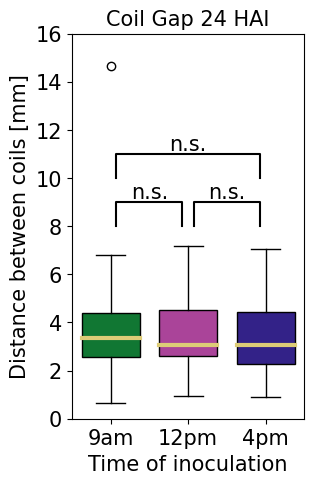

In [22]:
fig, ax = plt.subplots(1,1, figsize=(3,5), sharey=True, sharex=True)
ax = np.atleast_1d(ax).ravel(); i=0

hmax = 9

print('Gap\tmedian\tmean\tstd\tsem')
for i in range(len(foo)):
    foo[i] = tight[ Times[i] ]
    print(Times[i], np.round([np.median(foo[i]), np.mean(foo[i]), np.std(foo[i]), np.std(foo[i])/np.sqrt(len(foo[i]))], 2) , sep='\t')

bplot = ax[0].boxplot(foo, 
                      widths=0.75, patch_artist=True, 
                      medianprops={'lw':3, 'color':colors[5], 'alpha':1}, zorder=3)
for patch, color in zip(bplot['boxes'], colors[:len(Times)]):
    patch.set_facecolor(color)

for ix,(i,j) in enumerate(it.combinations(range(len(Times)), 2)):
    if i+j == 2:
        epsy = 2
    else:
        epsy = 0
    xfoo = np.array([i+1+epsx, i+1+epsx, j+1-epsx, j+1-epsx])
    yfoo = np.array([hmax-1,hmax,hmax,hmax-1]) + epsy
    ax[0].text((xfoo[0] + xfoo[2])*.5, yfoo[0]+1, smwhit[0,ix], ha='center', va='bottom', color='k', fontsize=fs)
    ax[0].plot(xfoo, yfoo, lw=1.5, c='k')

i = 0
ax[i].set_ylim((0,16))
ax[i].tick_params(labelsize=fs);
ax[i].set_xticks(np.arange(len(Times)) + 1, Times, fontsize=fs);
ax[i].set_ylabel('Distance between coils [mm]', fontsize=fs);
ax[i].set_xlabel('Time of inoculation', fontsize=fs)
ax[i].set_title('Coil Gap 24 HAI', fontsize=fs);

filename = dst + 'coil_tightness'
plt.savefig(filename + '.svg', format='svg', bbox_inches='tight')
plt.savefig(filename + '.jpg', format='jpg', dpi=200, pil_kwargs={'optimize':True}, bbox_inches='tight')

# Check at which timestamp the cuscuta stops varying its position

## Consider how fast the cuscuta gets to this terminal position

In [185]:
hmax = max([np.max(stables[Times[i]]) for i in range(len(Times))] + [np.max(manu[Times[i]][:,1]) for i in range(len(Times))])
hmin = min([np.min(stables[Times[i]]) for i in range(len(Times))] + [np.min(manu[Times[i]][:,1]) for i in range(len(Times))])
print(hmax, hmin)

mwhit = np.zeros((3,3))

for ix,(i,j) in enumerate(it.combinations(range(len(Times)), 2)):
    mwhit[ix, 0] = stats.mannwhitneyu(manu[Times[i]][:,1], manu[Times[j]][:, 1], method='exact').pvalue
    print('Manual\t',Times[i],'vs',Times[j],'\tMann-Whitney U-test p-val:',mwhit[ix,0])
    for k in range(2):
        mwhit[ix,k+1] = stats.mannwhitneyu(stables[Times[i]][:,k], stables[Times[j]][:, k], method='exact').pvalue
        print('Coil', k+1, '\t', Times[i],'vs',Times[j],'\tMann-Whitney U-test p-val:', mwhit[ix,k+1])
    print('---')

smwhit = singifmtx(mwhit, limits)
print(smwhit)

24.0 4.0
Manual	 9am vs 12pm 	Mann-Whitney U-test p-val: 0.023577990897164794
Coil 1 	 9am vs 12pm 	Mann-Whitney U-test p-val: 0.45438803078681034
Coil 2 	 9am vs 12pm 	Mann-Whitney U-test p-val: 0.08478328879351145
---
Manual	 9am vs 4pm 	Mann-Whitney U-test p-val: 0.00011903475720986779
Coil 1 	 9am vs 4pm 	Mann-Whitney U-test p-val: 0.09108331873999058
Coil 2 	 9am vs 4pm 	Mann-Whitney U-test p-val: 0.00022849254526133162
---
Manual	 12pm vs 4pm 	Mann-Whitney U-test p-val: 0.0639217694402616
Coil 1 	 12pm vs 4pm 	Mann-Whitney U-test p-val: 0.32040590857582635
Coil 2 	 12pm vs 4pm 	Mann-Whitney U-test p-val: 0.019715822784854786
---
[['*' 'n.s.' 'n.s.']
 ['***' 'n.s.' '***']
 ['n.s.' 'n.s.' '*']]


Manual	median	mean	std	sem
9am	[15.   14.43  3.37  0.57]
12pm	[16.   16.48  2.96  0.55]
4pm	[18.   18.    3.07  0.57]

Coil 1	median	mean	std	sem
9am	[14.6  14.83  4.4   0.75]
12pm	[14.27 15.88  3.69  0.81]
4pm	[16.36 16.65  3.62  0.68]

Coil 2	median	mean	std	sem
9am	[11.96 13.32  4.12  0.71]
12pm	[15.52 15.18  3.64  0.79]
4pm	[18.05 17.35  3.38  0.64]


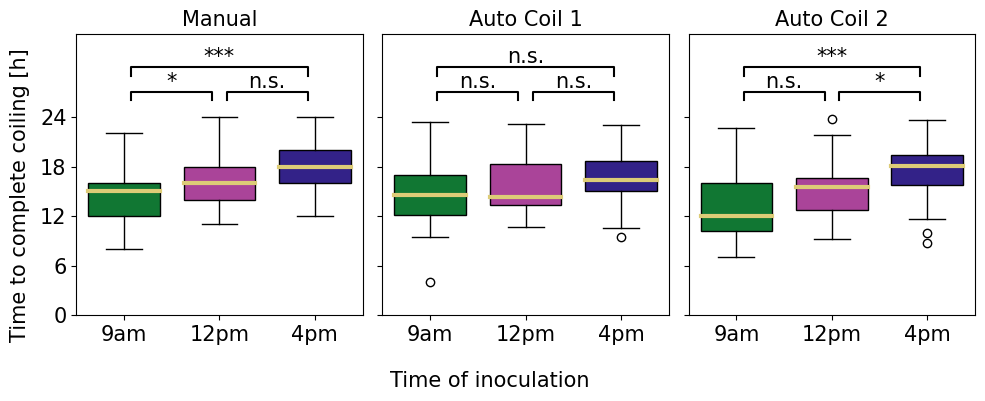

In [186]:
hmax = 27

fig, ax = plt.subplots(1,3, figsize=(10,4), sharey=True, sharex=True)
ax = np.atleast_1d(ax).ravel()    

print('Manual\tmedian\tmean\tstd\tsem'.format(k+1))
for i in range(len(foo)):
    foo[i] = manu[Times[i]][:,1]
    print(Times[i], np.round([np.median(foo[i]), np.mean(foo[i]), np.std(foo[i]), np.std(foo[i])/np.sqrt(len(foo[i]))], 2) , sep='\t')
    
ax[0].set_title('Manual', fontsize=fs)
bplot = ax[0].boxplot(foo, widths=0.75, patch_artist=True, 
                  medianprops={'lw':3, 'color':colors[5]})
for patch, color in zip(bplot['boxes'], colors[:len(Times)]):
    patch.set_facecolor(color)


for k in range(2):
    print('\nCoil {}\tmedian\tmean\tstd\tsem'.format(k+1))
    for i in range(len(foo)):
        foo[i] = stables[Times[i]][:,k]
        print(Times[i], np.round([np.median(foo[i]), np.mean(foo[i]), np.std(foo[i]), np.std(foo[i])/np.sqrt(len(foo[i]))], 2) , sep='\t')
        
    ax[k+1].set_title('Auto Coil {}'.format(k+1), fontsize=fs)
    bplot = ax[k+1].boxplot(foo, widths=0.75, patch_artist=True, 
                      medianprops={'lw':3, 'color':colors[5]})
    for patch, color in zip(bplot['boxes'], colors[:len(Times)]):
        patch.set_facecolor(color)

epsx = 0.075
for ix,(i,j) in enumerate(it.combinations(range(len(Times)), 2)):
    if i+j == 2:
        epsy = 3
    else:
        epsy = 0
    xfoo = np.array([i+1+epsx, i+1+epsx, j+1-epsx, j+1-epsx])
    yfoo = np.array([hmax-1,hmax,hmax,hmax-1]) + epsy
    
    for k in range(len(ax)):    
        ax[k].text((xfoo[0] + xfoo[2])*.5, yfoo[0]+1, smwhit[ix,k], ha='center', va='bottom', color='k', fontsize=fs)
        ax[k].plot(xfoo, yfoo, lw=1.5, c='k')

yticks = np.arange(0,5)*6
for i in range(len(ax)):
    #ax[i].margins(x = 0.05)
    ax[i].set_xticks(range(1,4), Times)
    ax[i].tick_params(labelsize=fs)
    ax[i].set_ylim((0,34))
    ax[i].set_yticks(yticks, yticks)

fig.supxlabel('Time of inoculation', fontsize=fs)
fig.supylabel('Time to complete coiling [h]', fontsize=fs)
fig.tight_layout();

filename = dst + 'time_to_complete_coiling'
plt.savefig(filename + '.svg', format='svg', bbox_inches='tight')
plt.savefig(filename + '.jpg', format='jpg', dpi=200, pil_kwargs={'optimize':True}, bbox_inches='tight')

In [163]:
hmax = max([np.max(quicks[Times[i]]) for i in range(len(Times))])
hmin = min([np.min(quicks[Times[i]]) for i in range(len(Times))])
print(hmax, hmin)

mwhit = np.zeros((3,2))

for ix,(i,j) in enumerate(it.combinations(range(len(Times)), 2)):
    for k in range(2):
        mwhit[ix,k] = stats.mannwhitneyu(quicks[Times[i]][:,k], quicks[Times[j]][:,k], method='exact').pvalue
        print('Coil', k+1, '\t', Times[i],'vs',Times[j],'\tMann-Whitney U-test p-val:', mwhit[ix,k])
    print('---')
smwhit = singifmtx(mwhit, limits)
print(smwhit)

17.69882163653594 0.130217950686232
Coil 1 	 9am vs 12pm 	Mann-Whitney U-test p-val: 0.5191502905841494
Coil 2 	 9am vs 12pm 	Mann-Whitney U-test p-val: 0.25169573786658345
---
Coil 1 	 9am vs 4pm 	Mann-Whitney U-test p-val: 0.1970629833347273
Coil 2 	 9am vs 4pm 	Mann-Whitney U-test p-val: 0.6993138782295811
---
Coil 1 	 12pm vs 4pm 	Mann-Whitney U-test p-val: 0.03754876884799503
Coil 2 	 12pm vs 4pm 	Mann-Whitney U-test p-val: 0.5279580244565482
---
[['n.s.' 'n.s.']
 ['n.s.' 'n.s.']
 ['*' 'n.s.']]



Coil 1	median	mean	std	sem
9am	[ 9.69 10.    3.95  0.68]
12pm	[ 9.71 10.59  3.29  0.72]
4pm	[8.35 8.72 3.35 0.63]

Coil 2	median	mean	std	sem
9am	[4.32 5.56 3.7  0.63]
12pm	[4.67 6.53 4.04 0.88]
4pm	[4.67 5.46 3.11 0.59]


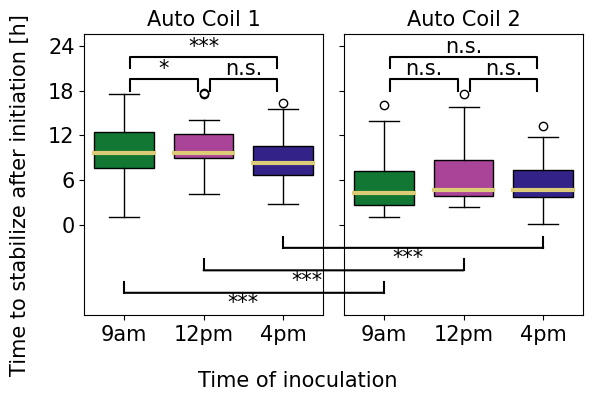

In [187]:
hmax = 19.5
eps = 1.5

fig, ax = plt.subplots(1,2, figsize=(6,4), sharey=True, sharex=True)
ax = np.atleast_1d(ax).ravel()    

for k in range(len(ax)):
    print('\nCoil {}\tmedian\tmean\tstd\tsem'.format(k+1))
    for i in range(len(foo)):
        foo[i] = quicks[Times[i]][:,k]
        print(Times[i], np.round([np.median(foo[i]), np.mean(foo[i]), np.std(foo[i]), np.std(foo[i])/np.sqrt(len(foo[i]))], 2) , sep='\t')
        
    ax[k].set_title('Auto Coil {}'.format(k+1), fontsize=fs)
    bplot = ax[k].boxplot(foo, widths=0.75, patch_artist=True, 
                      medianprops={'lw':3, 'color':colors[5]})
    for patch, color in zip(bplot['boxes'], colors[:len(Times)]):
        patch.set_facecolor(color)

    ax[k].set_xticks(range(1,4), Times)
    ax[k].tick_params(labelsize=fs)
    ax[k].set_ylim((-12, 25.5))


epsx = 0.075
for ix,(i,j) in enumerate(it.combinations(range(len(Times)), 2)):
    if i+j == 2:
        epsy = 3
    else:
        epsy = 0
    xfoo = np.array([i+1+epsx, i+1+epsx, j+1-epsx, j+1-epsx])
    yfoo = np.array([hmax-eps,hmax,hmax,hmax-eps]) + epsy
    
    for k in range(len(ax)):    
        ax[k].text((xfoo[0] + xfoo[2])*.5, yfoo[0]+eps, smwhit[ix,k], ha='center', va='bottom', color='k', fontsize=fs)
        ax[k].plot(xfoo, yfoo, lw=1.5, c='k')

yvals = -2*eps*(np.arange(2, -1, -1) + 1)

for i in range(len(yvals)):
    xy = (i+1, yvals[i])
    con = connpatch(xyA=xy, xyB=xy, coordsA='data', coordsB='data',
                    axesA=ax[0], axesB=ax[1], color="k", lw=1.5)
    ax[1].add_artist(con)

for i in range(len(yvals)):
    for j in range(len(ax)):
        ax[j].plot([i+1, i+1], [yvals[i]+eps, yvals[i]], lw=1.5, c='k')

ax[0].text( 2.5, yvals[0]-epsx, '***', ha='center', va='top', color='k', fontsize=fs)
ax[0].text( 3.3, yvals[1]-epsx, '***', ha='center', va='top', color='k', fontsize=fs)
ax[1].text( 1.3, yvals[2]-epsx, '***', ha='center', va='top', color='k', fontsize=fs)

ax[0].set_yticks(yticks, yticks)

fig.supxlabel('Time of inoculation', fontsize=fs)
fig.supylabel('Time to stabilize after initiation [h]', fontsize=fs)
fig.tight_layout();

filename = dst + 'time_btwn_initiation_and_completion'
#plt.savefig(filename + '.svg', format='svg', bbox_inches='tight')
#plt.savefig(filename + '.jpg', format='jpg', dpi=200, pil_kwargs={'optimize':True}, bbox_inches='tight')

In [170]:
for i in range(len(Times)):
    print(Times[i], '\tcoil 1 vs 2\t', stats.mannwhitneyu(quicks[Times[i]][:,0], quicks[Times[i]][:,1], method='exact'))

9am 	coil 1 vs 2	 MannwhitneyuResult(statistic=925.0, pvalue=9.920446114082275e-06)
12pm 	coil 1 vs 2	 MannwhitneyuResult(statistic=363.0, pvalue=0.00019433670916348147)
4pm 	coil 1 vs 2	 MannwhitneyuResult(statistic=606.0, pvalue=0.00031972269039838916)


In [250]:
singifscalar(corr.pvalue)

'n.s.'

[[ 0.53216196 -0.23506494 -0.07553366]
 [ 0.10863254 -0.1961039  -0.32785988]]

[[0.00119765 0.30503029 0.70245358]
 [0.54083401 0.39424166 0.0885272 ]]


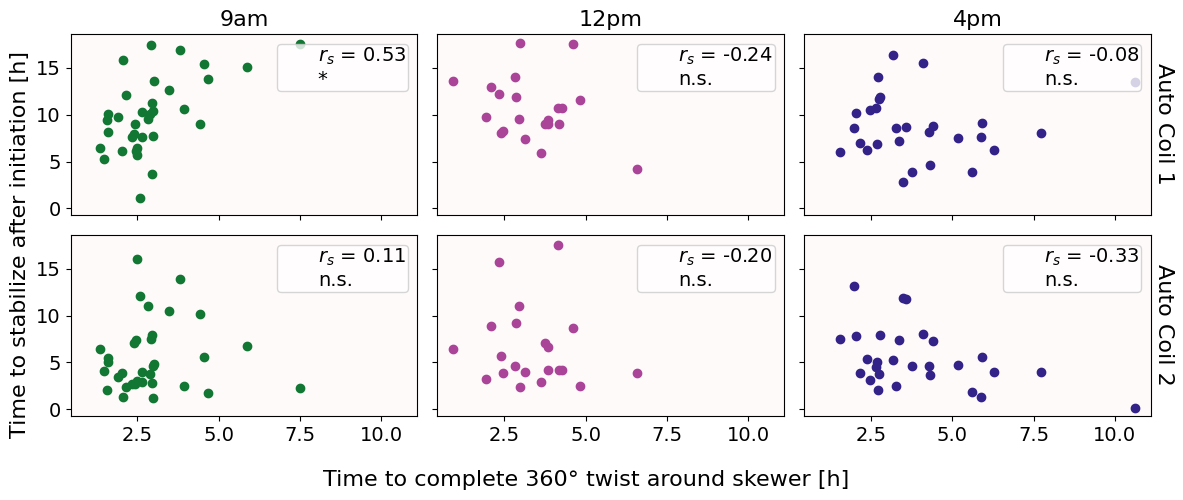

In [254]:
r2s = np.zeros((2,3))
r2p = np.copy(r2s)

fig, ax = plt.subplots(2,3, figsize=(12,5), sharey=True, sharex=True)
#ax = np.atleast_1d(ax).ravel(); i=0

for i in range(len(Times)):
    key = Times[i]
    for j in range(2):
        #r2[j,i] = metrics.r2_score(speed[key], quicks[key][:,j])
        corr = stats.spearmanr(speed[key], quicks[key][:,j])
        r2s[j,i] = corr.statistic
        r2p[j,i] = corr.pvalue
        
        ax[j,i].tick_params(labelsize=14)
        ax[j,i].scatter(speed[key], quicks[key][:,j], c=colors[i], label='$r_s$ = {:.2f}\n{}'.format(corr.statistic, singifscalar(corr.pvalue)) )
        ax[j,i].legend(loc='upper right', fontsize=14, markerscale=0, borderpad=0.1, handletextpad=0)
        ax[j,i].set_facecolor('snow')
    
    ax[0,i].set_title(key, fontsize=16)

for i in range(2):
    ax[i,-1].text(11.5, 9, 'Auto Coil {}'.format(i+1), ha='center', va='center', color='k', rotation=270, fontsize=16)

fig.supxlabel('Time to complete 360° twist around skewer [h]', fontsize=16)
fig.supylabel('Time to stabilize after initiation [h]', fontsize=16)
fig.tight_layout()

print(r2s, '\n\n', r2p, sep='')

filename = dst + 'stabilization_vs_twisting'
plt.savefig(filename + '.svg', format='svg', bbox_inches='tight')
plt.savefig(filename + '.jpg', format='jpg', dpi=200, pil_kwargs={'optimize':True}, bbox_inches='tight')